In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [2]:
# Read xls file with manufacturer recommended maintenances and save it to csv
data_xls = pd.read_excel('DB_v1.xlsx')
data_xls.to_csv('DB_v1.csv', encoding='utf-8',index=False)
df0 = pd.read_csv('DB_v1.csv')

In [3]:
# One hot encoding for fuel type and services/parts changed
manuf_df = pd.get_dummies(df0, prefix='', prefix_sep='', columns=['fuel','part_serv_name'])

In [4]:
manuf_df.columns

Index(['date_time', 'brand', 'model', 'year', 'trim', 'engine_displ',
       'transmission_type', 'doors', 'body_var', 'license_plate', 'km',
       'unit_price', 'quant', 'total_price', 'currency', 'country',
       'state_shop', 'city_shop', 'neighborhood_shop', 'zip_shop', 'name_shop',
       'data_type', 'Diesel', 'Flex', 'A/C cabin filter', 'Brake fluid',
       'Clutch fluid', 'Engine air filter', 'Engine oil', 'Engine oil filter',
       'Fuel filter', 'Spark plug', 'Timing belt', 'Timing belt tensioner',
       'Transmission fluid', 'Utilities belt'],
      dtype='object')

In [5]:
# Dropping some columns that will not be used at the moment
manuf_df = manuf_df[['brand', 'model', 'year', 'trim', 'engine_displ',
       'transmission_type', 'doors', 'body_var', 'km','country',
       'Diesel', 'Flex', 'A/C cabin filter', 'Brake fluid',
       'Clutch fluid', 'Engine air filter', 'Engine oil', 'Engine oil filter',
       'Fuel filter', 'Spark plug', 'Timing belt', 'Timing belt tensioner',
       'Transmission fluid', 'Utilities belt']]

In [6]:
# Grouping by specific maintenance occurrences (ex: brand, vehicle and trim at 10kkm) 
manuf_df = manuf_df.groupby(by=['brand', 'model', 'year', 'trim', 'engine_displ',
       'transmission_type', 'doors', 'body_var', 'km', 'country', 'Diesel', 'Flex']).sum().reset_index()

In [7]:
# renaming and dropping some columns for manual data
manuf_df = manuf_df.rename(columns={'Diesel':'diesel', 'Flex':'flex',
       'A/C cabin filter':'ac_cabin_filter', 'Brake fluid':'brake_fluid', 'Clutch fluid':'clutch_fluid',
                          'Engine air filter':'air_filter','Engine oil':'engine_oil',
                          'Engine oil filter':'engine_oil_filter',
                          'Fuel filter':'fuel_filter',
                          'Spark plug':'spark_plug',
                          'Timing belt':'timing_belt',
                          'Timing belt tensioner':'timing_belt_tensioner',
                          'Transmission fluid':'transmission_fluid',
                          'Utilities belt':'utilities_belt'})

In [20]:
manuf_df.columns

Index(['brand', 'model', 'year', 'trim', 'engine_displ', 'transmission_type',
       'doors', 'body_var', 'km', 'country', 'diesel', 'flex',
       'ac_cabin_filter', 'brake_fluid', 'clutch_fluid', 'air_filter',
       'engine_oil', 'engine_oil_filter', 'fuel_filter', 'spark_plug',
       'timing_belt', 'timing_belt_tensioner', 'transmission_fluid',
       'utilities_belt'],
      dtype='object')

In [8]:
# Reading real world maintenance data from kaggle
# available at https://www.kaggle.com/navins7/vehicle-maintenance-record?select=Vehicle+Maintenance-+Standard+Components+Cost.csv
real_df = pd.read_csv('Vehicle_Maintenance_Service_Records.csv')

In [9]:
# drop some that wont be needed
real_df = real_df.drop(columns=['slno','vehicle_type','mileage_range'])

# one hot encoding for fuel type
real_df = pd.get_dummies(real_df, prefix='', prefix_sep='', columns=['engine_type'])

# renaming and dropping some columns for real data
real_df = real_df.rename(columns={'make_year': 'year', 'mileage': 'km',
                        'air_clean_filter': 'air_filter','dust_and_pollen_filter':'ac_cabin_filter'})

real_df = real_df.drop(columns={'region','whell_alignment_and_balancing'})

In [10]:
real_df.columns

Index(['brand', 'model', 'year', 'km', 'oil_filter', 'engine_oil',
       'washer_plug_drain', 'ac_cabin_filter', 'air_filter', 'fuel_filter',
       'spark_plug', 'brake_fluid', 'brake_and_clutch_oil',
       'transmission_fluid', 'brake_pads', 'clutch', 'coolant', 'cost',
       'diesel', 'petrol'],
      dtype='object')

In [182]:
# Trying to predict clutch changes
X_train, X_test, y_train, y_test = train_test_split(real_df[['year', 'km', 'oil_filter', 'engine_oil','washer_plug_drain',
                                                            'ac_cabin_filter', 'air_filter', 'fuel_filter','spark_plug',
                                                            'brake_fluid', 'brake_and_clutch_oil','transmission_fluid',
                                                            'brake_pads','diesel','coolant',
                                                            'petrol']], real_df[['clutch']], test_size=0.25, random_state=42)

# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [183]:
classifier = KNeighborsClassifier(n_neighbors=6)

In [184]:
y_trainvec = np.ravel(y_train)
classifier.fit(X_train, y_trainvec)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [185]:
y_pred = classifier.predict(X_test)

In [186]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[250   0]
 [  4  31]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       250
           1       1.00      0.89      0.94        35

    accuracy                           0.99       285
   macro avg       0.99      0.94      0.97       285
weighted avg       0.99      0.99      0.99       285



Minimum error at 3 K neighbors


Text(0, 0.5, 'Mean Error')

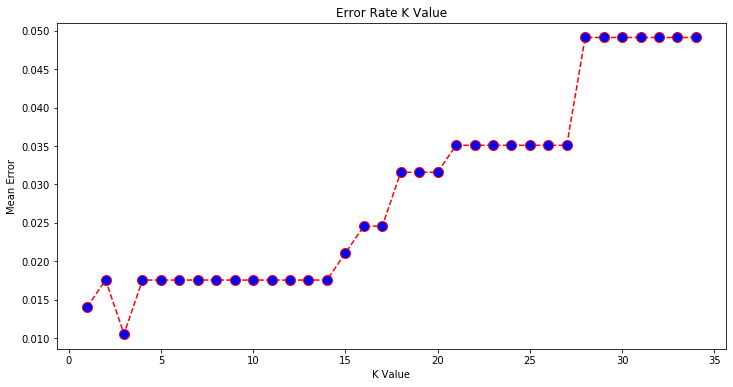

In [181]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 35):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_trainvec)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != np.ravel(y_test)))

print('Minimum error at', error.index(min(error))+1, 'K neighbors')
plt.figure(figsize=(12, 6))
plt.plot(range(1, 35), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [169]:
apriori_mask_real = ['ac_cabin_filter','fuel_filter','spark_plug', 'brake_fluid', 'brake_and_clutch_oil',
                'transmission_fluid', 'brake_pads', 'clutch', 'coolant']

In [143]:
apriori_df = real_df[apriori_mask_real]

In [144]:
frequent_itemsets = apriori(apriori_df, min_support=0.1, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [148]:
len(frequent_itemsets)

9

In [149]:
frequent_itemsets

,support,itemsets,length
0,0.279192,(ac_cabin_filter),1
1,0.287094,(fuel_filter),1
2,0.151888,(brake_fluid),1
3,0.134328,(brake_and_clutch_oil),1
4,0.142230,(transmission_fluid),1
5,0.141352,(brake_pads),1
6,0.132572,(clutch),1
7,0.159789,"(ac_cabin_filter, fuel_filter)",2
8,0.118525,"(transmission_fluid, brake_fluid)",2


In [150]:
rules = association_rules(frequent_itemsets)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(transmission_fluid),(brake_fluid),0.14223,0.151888,0.118525,0.833333,5.486513,0.096922,5.088674
